In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers

import numpy as np

The target at time n will be sin(x1<sub>n-1</sub>/4) + x2<sub>n-1</sub> where x1 and x2 are features. x1<sub>n</sub> = x1<sub>n-1</sub> + 1. x2<sub>n</sub> = MIN(MAX(x2<sub>n-1</sub>, -3), 3) + a randomly generated number between -1 and 1. The LAG response will be a binary variable if positive/negative

In [2]:
import pandas as pd

df = pd.read_csv('data/data_temporal.csv')
df['response_categorical'] = df['response'].apply(lambda x: True if x < 0 else False)

df = df.dropna()
df_original = df.copy()
dates = df.pop('date')

for col in df.columns: 
    df = df.rename({col: col.replace(' ', '_').replace('&', '')}, axis=1)

In [3]:
### normalize features
from sklearn.preprocessing import StandardScaler
xCategorical = df.pop('response_categorical')

def normalize_column(df):
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df.values), columns = df.columns, index= df.index)
    df = pd.DataFrame(np.clip(df, -5, 5), columns = df.columns, index= df.index)
    return df
        
df = normalize_column(df)
df['response_categorical'] = xCategorical.values

df.describe()

,x1,x2,response
count,7.370000e+02,7.370000e+02,7.370000e+02
mean,-3.856406e-17,9.821783e-17,-1.024358e-16
std,1.000679e+00,1.000679e+00,1.000679e+00
min,-1.729702e+00,-2.460622e+00,-2.551562e+00
25%,-8.648511e-01,-7.867571e-01,-7.571602e-01
50%,0.000000e+00,1.394495e-01,9.046393e-02
75%,8.648511e-01,7.885823e-01,7.769998e-01
max,1.729702e+00,1.743526e+00,2.151954e+00


In [4]:
df

,x1,x2,response,response_categorical
1,-1.729702,-1.081378,-0.603535,True
2,-1.725002,-0.711769,-0.692751,True
3,-1.720302,-0.540192,-0.260794,False
4,-1.715601,-0.728832,-0.043545,False
5,-1.710901,-0.928202,-0.198687,False
...,...,...,...,...
733,1.710901,-1.998981,-1.501794,True
734,1.715601,-2.131935,-1.406318,True
735,1.720302,-2.079564,-1.544312,True
736,1.725002,-1.887077,-1.536448,True


In [5]:
def df_to_dataset(df_features, df_labels, batch_size=32, single_step=False):
    test_split = int(len(df_features) * 0.8)
    validation_split = int(test_split * 0.6)
    
    x_train, y_train = create_multivariate_data(df_features, df_labels, 0,
                                                       validation_split, past_history,
                                                       future_target, single_step)
    x_val, y_val = create_multivariate_data(df_features, df_labels,
                                                   validation_split, test_split, past_history,
                                                   future_target, single_step)
    x_test, y_test = create_multivariate_data(df_features, df_labels,
                                                   test_split, None, past_history,
                                                   future_target, single_step)
    print("Training data", x_train.shape)
    print("Validation data", x_val.shape)
    print("Test data", x_test.shape)
    train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_data = train_data.shuffle(len(df_features)).batch(batch_size)
    
    val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_data = val_data.batch(batch_size)
    
    test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    test_data = test_data.batch(1)

    return x_train.shape[-2:], train_data, val_data, test_data
    

In [6]:
def create_multivariate_data(features, target, start_index, end_index, history_size, target_size, single_step=False):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(features) - target_size
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(features[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
            
    return np.asarray(data), np.asarray(labels)

In [7]:
features = [
            #'x1',
            #'x2',
            'response'
          ]

df_features = df[features]
df_features.head()

df_features = df_features.values

#time window parameters for the model
past_history = 30
future_target = 0 #note: smallest index is 0 if single step, 1 if multi step
is_single_step = True

shape, train_data, val_data, test_data = df_to_dataset(df_features, df["response_categorical"].values, 
                                                       batch_size=int((len(df_features)-past_history)), single_step=is_single_step)

Training data (323, 30, 1)
Validation data (206, 30, 1)
Test data (118, 30, 1)


In [8]:
import matplotlib.pyplot as plt

def create_time_steps(length):
  return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    if true_future:
        plt.plot(np.arange(num_out), np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show

def plot_train_history(history, title, other_metric=None):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    
    fig, ax1 = plt.subplots()
    ax1.plot(epochs, loss, 'b', label='Training loss')
    ax1.plot(epochs, val_loss, 'r', label='Validation loss')
    if other_metric:
        ax2 = ax1.twinx()
        ax2.plot(epochs, history.history[other_metric], 'g', label=other_metric)
    plt.title(title)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.show() 
    
if not is_single_step:
    for x, y in train_data.take(1):
        multi_step_plot(x[0], y[0], np.array([0]))

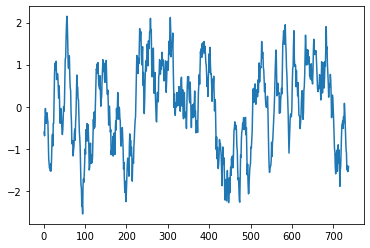

In [9]:
plt.plot( df["response"], label='Response')
plt.show()

{False: 0.7790697674418605, True: 1.3958333333333335}
False    473
True     264
Name: response_categorical, dtype: int64


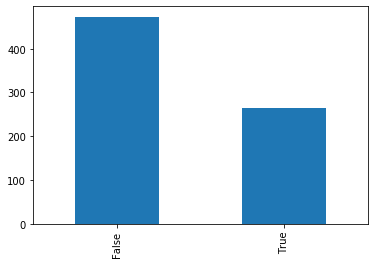

In [10]:
### overweighing negative response_categorical y category
## note: cannot oversample categorical y to rebalance since will lose past history information
weight_negative = (1/df['response_categorical'].value_counts()[True]) * len(df['response_categorical'])/2.0
weight_positive = (1/df['response_categorical'].value_counts()[False]) * len(df['response_categorical'])/2.0
class_weight = {False: weight_positive, True: weight_negative}

print(class_weight)
print(df['response_categorical'].value_counts())
df['response_categorical'].value_counts().plot(kind='bar')

In [11]:
def make_model(bias, threshold, shape):
    if bias is not None:
        bias = keras.initializers.Constant(bias)
    model = tf.keras.Sequential()
    #add LSTM layer
    #model.add(layers.LSTM(1280, input_shape=shape))
    model.add(layers.LSTM(1280, return_sequences=True, input_shape=shape))
    model.add(layers.LSTM(640, return_sequences=True))
    model.add(layers.LSTM(80))
    
    model.add(layers.Dense(2000, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10000, activation='relu'))
    
    # Add the output layer:
    output_unit = 1 if not is_single_step else future_target + 1
    model.add(layers.Dense(output_unit, activation='sigmoid', bias_initializer= bias))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.BinaryAccuracy(threshold=threshold), keras.metrics.Precision(thresholds=threshold), 
                           keras.metrics.Recall(thresholds=threshold), keras.metrics.AUC(name='auc')])
    
    return model

In [12]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_auc", min_delta=0.001, patience=10, mode="max")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("bestcheckpoint_RNN.h5", monitor="val_auc", save_best_only=True, mode="max")

In [13]:
model = make_model(None, 0.6, shape)
history = model.fit(train_data, epochs=500, validation_data=val_data, 
                    class_weight=class_weight, callbacks=[earlystop_callback, checkpoint_callback])

if not is_single_step:
    for x, y in val_data.take(10):
        multi_step_plot(x[0], y[0], model.predict(x)[0])

Epoch 1/500
1/1 [==============================] - 33s 33s/step - loss: 0.7197 - binary_accuracy: 0.6780 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5046 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/500
1/1 [==============================] - 9s 9s/step - loss: 0.5777 - binary_accuracy: 0.6780 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8143 - val_loss: 1.7741 - val_binary_accuracy: 0.6262 - val_precision: 0.5965 - val_recall: 0.6869 - val_auc: 0.7320
Epoch 3/500
1/1 [==============================] - 11s 11s/step - loss: 1.2493 - binary_accuracy: 0.7152 - precision: 0.5469 - recall: 0.6731 - auc: 0.7424 - val_loss: 0.5319 - val_binary_accuracy: 0.5194 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8734
Epoch 4/500
1/1 [==============================] - 9s 9s/step - loss: 0.4996 - binary_accuracy: 0.6780 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc:

<Figure size 432x288 with 0 Axes>

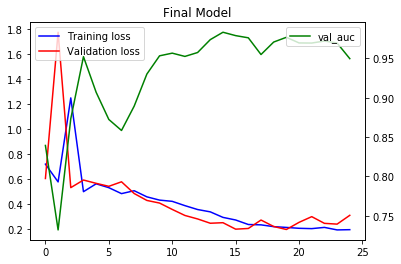

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 1280)          6563840   
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 640)           4917760   
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                230720    
_________________________________________________________________
dense (Dense)                (None, 2000)              162000    
_________________________________________________________________
dropout (Dropout)            (None, 2000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10000)             20010000  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [14]:
plot_train_history(history, 'Final Model', 'val_auc')

#model = tf.keras.models.load_model("bestcheckpoint_RNN.h5")

model.summary()

In [15]:
model.evaluate(test_data)

predict_data = []

for x, y in test_data:
    real_x = []
    for history_item in x[0].numpy():
        real_x.append(df.loc[df[features[0]] == history_item[0]])

    predict_y = float(model.predict(x)[0])
    #print(x[0].numpy(), y[0].numpy(), predict_y)
    if (predict_y > 0.5 and y[0].numpy() == True) or (predict_y < 0.5 and y[0].numpy() == False):
        predicted_correctly = 1
    else:
        predicted_correctly = 0
        
    values = real_x[len(real_x)-1][features].values[0].tolist() #note: this is only getting the last row in past_history
    values.extend([y[0].numpy(), predict_y, predicted_correctly])
    predict_data.append(values)

predict_columns = features.copy()
predict_columns.extend(['Response is negative','Prob(response < 0)', "Predicted correctly"])

predicted = pd.DataFrame(predict_data, columns= predict_columns )
predicted.to_csv("RNNresults.csv")
predicted


118/118 [==============================] - 10s 82ms/step - loss: 0.2030 - binary_accuracy: 0.9237 - precision: 0.9310 - recall: 0.7941 - auc: 0.9636


,response,Response is negative,Prob(response < 0),Predicted correctly
0,-0.228088,True,0.145846,0
1,-0.521384,True,0.368514,0
2,-0.388222,False,0.691394,0
3,-0.227859,False,0.747930,0
4,0.107752,False,0.392164,1
...,...,...,...,...
113,-1.107380,True,0.994588,1
114,-1.501794,True,0.998829,1
115,-1.406318,True,0.999647,1
116,-1.544312,True,0.999823,1
